In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import glob
import os
import numpy as np

In [21]:
def find_files_by_extension(search_pattern):
    edf_files = glob.glob(search_pattern, recursive=True)
    return edf_files

In [22]:
search_pattern = pattern = r"C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\*\*\*.edf"
file_paths = find_files_by_extension(search_pattern)

for file_path in file_paths[:9]:
    print(file_path)

C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000046.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000076.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000080.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000093.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\train\0000002.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\train\0000004.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\train\0000008.edf
C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\train\0000009.edf


In [23]:
# !pip install mne

Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-04-10 22:53:59 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
>
Using matplotlib as 2D backend.


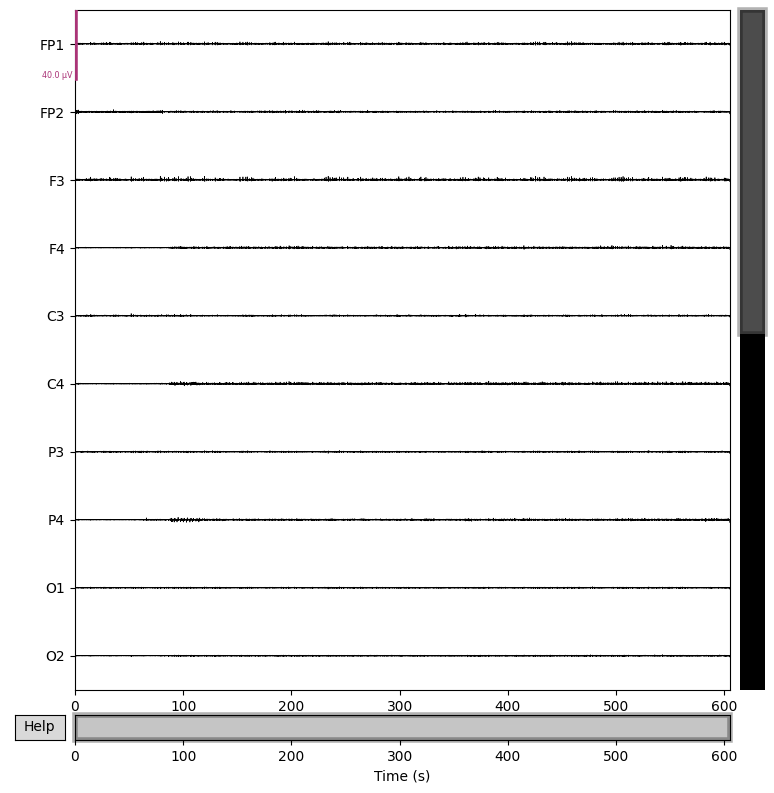

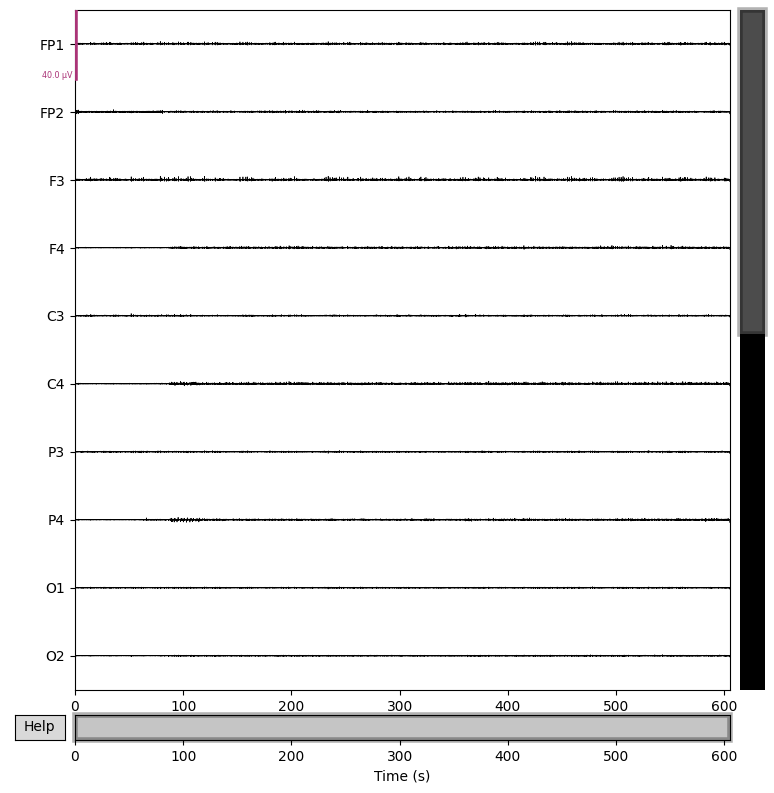

In [24]:
import mne
# Open the EDF file
# edf_file = mne.io.read_raw_edf(r'/content/0000002.edf')
edf_file = mne.io.read_raw_edf(r'C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf')
# Print basic information about the file
print(edf_file.info)
# Plot the raw data
edf_file.plot(duration=3000, n_channels=10)  # Adjust the duration and number of channels as needed


In [25]:
import numpy as np
from scipy import signal

def downsample_signal(original_sampling_freq, target_sampling_freq, signal_data):
    original_num_samples = signal_data.shape[1]
    original_time = np.arange(original_num_samples) / original_sampling_freq

    target_num_samples = int(original_num_samples * (target_sampling_freq / original_sampling_freq))
    target_time = np.arange(target_num_samples) / target_sampling_freq

    downsampled_signal = signal.resample(signal_data, target_num_samples, axis=1)

    return downsampled_signal

# Example usage:
original_sampling_freq = 200
target_sampling_freq = 100
eeg_data = edf_file.get_data()

downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)

# Example usage: Print the dimensions of the downsampled EEG data
print("original: ", eeg_data.shape)
print("downsampled: ", downsampled_eeg_data.shape)


original:  (21, 121000)
downsampled:  (21, 60500)


In [26]:
# Detrend
def detrend_signal(signal_data):
    detrended_signal = signal.detrend(signal_data, axis=1)
    return torch.tensor(detrended_signal, dtype=torch.float64)


detrended_eeg_data = detrend_signal(downsampled_eeg_data)

# Example usage: Print the dimensions of the detrended EEG data
print(detrended_eeg_data.shape)

torch.Size([21, 60500])


In [60]:
import pandas as pd
path = r"C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\new.csv"
def generate_label_ref(path):
    '''generates label ref dictionary from
    the csv file'''
    labels_file_path = path
    # Load the CSV file into a DataFrame
    df = pd.read_csv(labels_file_path)

    paths = df["paths"].tolist()
    labels = df["labels"].tolist()

    label_reference = dict(zip(paths, labels))
    
    return label_reference


label_reference = generate_label_ref(path)

In [90]:
def generate_unsegmented_dataset(file_paths, label_reference):
    xs = [] # list of tensors
    ys = [] # list of numbers

    xs_eval = []
    ys_eval = []

    for file_path in file_paths:
        # do not add eval data to the dataset
        if 'eval' in file_path:
            # if the label for the filepath is present in the reference, only then append label and path to dataset
            try:
                ys_eval.append(label_reference[file_path]) # numbers
            except:
                continue
            edf_file = mne.io.read_raw_edf(file_path)
            eeg_data = edf_file.get_data()
            downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
            detrended_eeg_data = detrend_signal(downsampled_eeg_data)  # tensor
            xs_eval.append(detrended_eeg_data)
        else:
            # if the label for the filepath is present in the reference, only then append label and path to dataset
            try:
                ys.append(label_reference[file_path]) # numbers
            except:
                continue
            edf_file = mne.io.read_raw_edf(file_path)
            eeg_data = edf_file.get_data()
            downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
            detrended_eeg_data = detrend_signal(downsampled_eeg_data)  # tensor
            xs.append(detrended_eeg_data)
    
    return xs, ys, xs_eval, ys_eval

In [91]:
X, Y, X_eval, Y_eval = generate_unsegmented_dataset(file_paths, label_reference)


Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000046.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000076.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000080.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000093.edf...
EDF file detected
Setting channel info stru

In [92]:
print(len(X))
print(len(Y))
print(len(X_eval))
print(len(Y_eval))

19
19
9
9


In [95]:
def segmented_dataset_builder(xs, ys, xs_eval, ys_eval, segment_length, dim):
    data_X = []
    data_Y = []

    data_X_eval = []
    data_Y_eval = []

    index = 0
    for tensor in xs:
        label = ys[index]
        for i in range(tensor.size(dim) // segment_length):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length

            # Extract the segment
            segment = tensor[:, start_idx:end_idx]

            # Update data arrays
            data_X.append(segment.tolist())
            data_Y.append(label)

    for tensor in xs_eval:
        label = ys_eval[index]
        for i in range(tensor.size(dim) // segment_length):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length

            # Extract the segment
            segment = tensor[:, start_idx:end_idx]

            # Update data arrays
            data_X_eval.append(segment.tolist())
            data_Y_eval.append(label)

        data_X = torch.tensor(data_X)
        data_Y = torch.tensor(data_Y)
        data_X_eval = torch.tensor(data_X_eval)
        data_Y_eval = torch.tensor(data_Y_eval)
        
        return data_X.double(), data_Y.double(), data_X_eval.double(), data_Y_eval.double()
    
data_X, data_Y, data_X_eval, data_Y_eval = segmented_dataset_builder(X, Y, X_eval, Y_eval, 150, 1)            

In [105]:
print(data_X.shape)
print(data_Y.shape)
print(data_X_eval.dtype)
print(data_Y_eval.dtype)

torch.Size([10366, 21, 150])
torch.Size([10366])
torch.float32
torch.int64


In [103]:
def get_batch(split, batch_size):
    if split == "train":
        data = data_X
        label = data_Y
    elif split == "eval":
        data = data_X_eval
        label = data_Y_eval

    ix = torch.randint(data.size(0), (batch_size,))
    x = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])

    return x, y
xb, yb = get_batch('train', 4)

In [40]:
label_reference[r"C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\train\0000002.edf"]

1

In [38]:
print(len(xs))

5


In [9]:
B = 1  # batch size

S = 21
C = 120
L = 150

M = L//5  # reduced temporal dimension

In [11]:
class CNN1D(nn.Module):
    def __init__(self, S=21, L=150, C=120):
        super().__init__()
        self.S = S
        self.L = L
        self.C = C
        self.conv_layer_1 = nn.Conv1d(1, C, kernel_size=4)
        self.conv_layer_2 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_3 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_4 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_1.double()  # Update the data type of the convolutional layer weights to torch.float64
        self.conv_layer_2.double()
        self.conv_layer_3.double()
        self.conv_layer_4.double()

    def forward(self, x):
        outputs = []
        for i in range(self.S):
            input_row = x[i].unsqueeze(0).unsqueeze(0)  # (batch_size=1, channels=1, length=num_columns)
            output_tensor = self.conv_layer_1(input_row)
            output_tensor = self.conv_layer_2(output_tensor)
            output_tensor = self.conv_layer_3(output_tensor)
            output_tensor = self.conv_layer_4(output_tensor)
            outputs.append(output_tensor)

        output_tensor = torch.cat(outputs, dim=0)
        return output_tensor

# # Get the number of rows and columns
# x = torch.tensor(detrended_eeg_data, dtype=torch.float64)
# num_rows, num_columns = detrended_eeg_data.shape

# # Define the Conv1D layer
# conv1d_layer = CNN1D(S=21, L=L, C=C)
# output = conv1d_layer(x)

# # Print output shape
# print(output.shape)

In [49]:
def segmentor(data):
    # # returns all batches and all channels, only segments the temporal dimension
    return data[:, :, :L] 

In [94]:
# Just taking a segment of eeg input along temporal dimension
output = segmentor(output)
print(output.shape)

torch.Size([21, 120, 150])


In [12]:
class RegionalHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, C, L):
        # Parameters are head_size(d), no. of tokens(C), and input embedding size(L)
        super().__init__()
        self.block_size = C
        self.n_embed = L
        self.head_size = head_size 
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.register_buffer('tril', torch.tril(torch.ones(self.block_size, self.block_size)))
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        B, S_, C_, L_ = x.shape
        x = x.view(S_, B, C_, L_)  # (B, T, C, L)
        matrices = []

        for spatial_mat in x:
            inp = spatial_mat
            # Below this, T is not the original T, but the head size
            k = self.key(inp)   # (B, C, T)
            q = self.query(inp) # (B, C, T)
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) * self.head_size**-0.5 # (B, C, T) @ (B, T, C) -> (B, C, C)
            wei = F.softmax(wei, dim=-1) # (B, C, C)
            wei = self.dropout(wei)
            # perform the weighted aggregation of the values
            v = self.value(inp) # (B, C, T)
            out = wei @ v # (B, C, C) @ (B, C, T) -> (B, C, T)
            matrices.append(out.tolist())

        matrices = torch.tensor(matrices)
        out = matrices.view(B, S_, C_, self.head_size)
        return out.double()

In [52]:
rh = RegionalHead(head_size=L//5, C=C, L=L)
rh_output = rh(output.unsqueeze(0))  # unsqueeze adds an extra batch dimension
print(rh_output.shape)

torch.Size([1, 21, 120, 30])


In [83]:
num_heads = 5

In [13]:
class RegionalMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, C, L):
        super().__init__()
        self.heads = nn.ModuleList([RegionalHead(head_size, C, L) for _ in range(num_heads)])
        self.proj = nn.Linear(L, L).double()
        self.dropout = nn.Dropout(0.001)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # out = self.dropout(self.proj(out)) # Instead of this line, we proceed as below:

        # Implementing projection layer after the multihead attention module
        b, s, c, l = out.shape
        out = out.view(s, b, c, l)

        matrices = []
        for inp in out:
            matrix = self.dropout(self.proj(inp))
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        matrices = matrices.view(b, s, c, l)

        return matrices.double()

In [54]:
mrh = RegionalMultiHeadAttention(5, head_size=L//5, C=C, L=L)
mrh_output = mrh(output.unsqueeze(0))
mrh_output.shape


torch.Size([1, 21, 120, 150])

In [14]:
class FeedFowardRegional(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, L): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L, 4*L), 
            nn.ReLU(),
            nn.Linear(4*L, L),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        b, s, c, l = x.shape
        x = x.view(s, b, c, l)

        matrices = []
        for inp in x:
            matrix = self.net(inp)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        # s_, b_, c_, l_ = matrices.shape
        matrices = matrices.view(b, s, c, l)


        return matrices.double()

In [56]:
ffr = FeedFowardRegional(L)
ffr_output = ffr(mrh_output)
print(ffr_output.shape)

torch.Size([1, 21, 120, 150])


In [15]:
class BlockRegional(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, L, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        D = L // n_head
        self.sa = RegionalMultiHeadAttention(n_head, D, C, L)
        self.ffwd = FeedFowardRegional(L)
        self.ln1 = nn.LayerNorm(L).double()
        self.ln2 = nn.LayerNorm(L).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [58]:
br = BlockRegional(L, 5)
br_output = br(output.unsqueeze(0))
print(br_output.shape)

torch.Size([1, 21, 120, 150])


In [17]:
def RegionalToSynchronousShapeShifter(tensor):
    b, s, c, l = tensor.shape
    return tensor.view(b, c, s, l)

sync_input = RegionalToSynchronousShapeShifter(br_output)
print(sync_input.shape)

Output of Regional block: [batch, S, C, L]


Input expected by Synchronous Block: [batch, C, S, L]

In [18]:
class SynchronousHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, S, L):
        # Parameters are head_size(d), no. of tokens(C), and input embedding size(L)
        super().__init__()
        self.block_size = S
        self.n_embed = L
        self.head_size = head_size 
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.register_buffer('tril', torch.tril(torch.ones(self.block_size, self.block_size)))
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        b, c, s, l= x.shape
        x = x.view(c, b, s, l)  # (C, B, S, L)
        matrices = []

        for spatial_mat in x:
            inp = spatial_mat
            k = self.key(inp)   # (B, S, D)
            q = self.query(inp) # (B, S, D)
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) * self.head_size**-0.5 # (B, S, D) @ (B, D, S) -> (B, S, S)
            wei = F.softmax(wei, dim=-1) # (B, S, S)
            wei = self.dropout(wei)
            # perform the weighted aggregation of the values
            v = self.value(inp) # (B, S, D)
            out = wei @ v # (B, S, S) @ (B, S, D) -> (B, S, D)
            matrices.append(out.tolist())

        matrices = torch.tensor(matrices)
        out = matrices.view(b, c, s, self.head_size)
        return out.double()

In [62]:
sh = SynchronousHead(head_size=L//5, S=S, L=L)
sh_output = sh(sync_input) # unsqueeze adds an extra batch dimension
print(sh_output.shape)

torch.Size([1, 120, 21, 30])


In [19]:
class SynchronousMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, S, L):
        super().__init__()
        self.heads = nn.ModuleList([SynchronousHead(head_size, S, L) for _ in range(num_heads)])
        self.proj = nn.Linear(L, L).double()
        self.dropout = nn.Dropout(0.001)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # out = self.dropout(self.proj(out)) # Instead of this line, we proceed as below:

        # Implementing projection layer after the multihead attention module
        b, c, s, l = out.shape
        out = out.view(c, b, s, l)

        matrices = []
        for inp in out:
            matrix = self.dropout(self.proj(inp))  # inp is (B, S, L)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        matrices = matrices.view(b, c, s, l)

        return matrices.double()

In [64]:
mhs = SynchronousMultiHeadAttention(5, head_size=L//5, S=S, L=L)
mhs_output = mhs(sync_input)
print(mhs_output.shape)


torch.Size([1, 120, 21, 150])


In [20]:
class FeedFowardSync(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, L): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L, 4*L), 
            nn.ReLU(),
            nn.Linear(4*L, L),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        b, c, s, l = x.shape
        x = x.view(c, b, s, l)

        matrices = []
        for inp in x:
            matrix = self.net(inp)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        # s_, b_, c_, l_ = matrices.shape
        matrices = matrices.view(b, c, s, l)


        return matrices.double()

In [66]:
ffs = FeedFowardSync(L)
ffs_output = ffs(mhs_output)
print(ffs_output.shape)

torch.Size([1, 120, 21, 150])


In [21]:
class BlockSync(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, L, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        D = L // n_head
        self.sa = SynchronousMultiHeadAttention(n_head, D, S, L)
        self.ffwd = FeedFowardSync(L)
        self.ln1 = nn.LayerNorm(L).double()
        self.ln2 = nn.LayerNorm(L).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [68]:
bs = BlockSync(L, 5)
bs_output = bs(sync_input)
print(bs_output.shape)

torch.Size([1, 120, 21, 150])


## Temporal Encoder

In [22]:
class TemporalTransformer(nn.Module):
    def __init__(self, S, C, L, M):
        super(TemporalTransformer, self).__init__()
        self.C = C  # Number of channels
        self.L = L  # Original temporal dimensionality
        self.S = S  # Spatial dimension
        self.M = M  # Compressed dimensionality
        
        self.patch_size = self.C * self.S  # Patch size
        self.M_linear = nn.Linear(self.patch_size, self.patch_size).double()  # Learnable matrix M
        
    def forward(self, z5):
        # z5: (B, C, S, D) input tensor
        # Recuce the temporal dimension to M
        z5_averaged = self.reduce_temporal_dimension(z5, self.M) # (B, C, S, M)
        # Reshape the tensor to B, M, S*C
        z5_reshaped = z5_averaged.reshape(z5.shape[0], -1, self.S*self.C)  # B, M, S*C
        # Get latent vectors out of the current tensor
        latent = self.M_linear(z5_reshaped) # (B, M, S*C)
        return latent
    
    def reduce_temporal_dimension(self, input_tensor, M):
        # input_tensor: (B, C, S, L) input tensor
        # M: Compressed dimensionality

        # Reshape the tensor to 3D
        reshaped_tensor = input_tensor.view(-1, input_tensor.size(2), input_tensor.size(3))  # Shape: (B*C, S, L)

        # Calculate the mean along the last dimension (L)
        averaged_tensor = torch.mean(reshaped_tensor, dim=-1)  # Shape: (B*C, S)

        # Resize the tensor to have the desired compressed dimensionality (M)
        resized_tensor = torch.nn.functional.interpolate(averaged_tensor.unsqueeze(-1), size=M, mode='linear', align_corners=False)
        resized_tensor = resized_tensor.squeeze(-1)

        # Reshape back to 4D
        output_tensor = resized_tensor.view(input_tensor.size(0), input_tensor.size(1), input_tensor.size(2), M)  # Shape: (B, C, S, M)

        return output_tensor


In [70]:
temporal = TemporalTransformer(S, C, L, M=L//5)  # M is 15 here
print(f'Input: {bs_output.shape}')
temporal_without_attention_output = temporal(bs_output)
print(f'Output: {temporal_without_attention_output.shape}')


Input: torch.Size([1, 120, 21, 150])
Output: torch.Size([1, 30, 2520])


In [23]:
class HeadTemporal(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embed):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False).double()
        self.query = nn.Linear(n_embed, head_size, bias=False).double()
        self.value = nn.Linear(n_embed, head_size, bias=False).double()

        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    
class MultiHeadAttentionTemporal(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embed):
        super().__init__()
        self.n_embed = n_embed
        self.heads = nn.ModuleList([HeadTemporal(head_size, self.n_embed) for _ in range(num_heads)])
        self.proj = nn.Linear(self.n_embed, self.n_embed).double()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFowardTemporal(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        return self.net(x)

class TemporalBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttentionTemporal(n_head, head_size, n_embd)
        self.ffwd = FeedFowardTemporal(n_embd)
        self.ln1 = nn.LayerNorm(n_embd).double()
        self.ln2 = nn.LayerNorm(n_embd).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [29]:
def product_of_2_least_common_factors(num):
    factors = []
    
    # Find all factors of the number
    for i in range(1, num + 1):
        if num % i == 0:
            factors.append(i)
        if len(factors) == 3:
            break
    
    ans = 1
    for factor in factors:
        ans = ans * factor
    
    return ans

product_of_2_least_common_factors(2520)

6

In [85]:
# Till now the shape of tensor is: B, N, D
# We don't want d to decrease, so we need to specify num_of_heads, and head_size carefully
# The product_of_2_least_common_factors function allows us to achieve this.
# It gives us a small number which can be used as the parameter: number of heads, as it's ouput divides d with no remainder
b, n, d = temporal_without_attention_output.shape
no_of_heads_for_temoral_block = product_of_2_least_common_factors(d)
bt = TemporalBlock(d, no_of_heads_for_temoral_block)

In [74]:
print(f'Input shape: {temporal_without_attention_output.shape}')
eeg_encoder_output = bt(temporal_without_attention_output)
print(f'Output shape: {eeg_encoder_output.shape}')

Input shape: torch.Size([1, 30, 2520])
Output shape: torch.Size([1, 30, 2520])


In [24]:
class Decoder(nn.Module):
    def __init__(self, B, M, S, C):
        super(Decoder, self).__init__()
        self.B = B
        self.M = M
        self.S = S
        self.C = C

        # Define the layers
        # Define the 1D convolutional filter - captures info along the convolutional dimension
        self.l1_filter = nn.Conv1d(M*S, M*S, kernel_size=C).double()
        # Define the l2 filter - captures info along spatial dimension
        self.l2_filter = nn.Conv1d(M, M, kernel_size=S).double()
        # PREDICTION NEURAL NETWORK
        self.layer0 = nn.Linear(M, 256).double()
        self.layer1 = nn.Linear(256, 64).double()
        self.layer2 = nn.Linear(64, 1).double()
        self.leaky_relu = nn.LeakyReLU().double()
        self.sigmoid = nn.Sigmoid().double()

    def forward(self, x):
        x = self.encoder_to_decoder_shape_transition(x)

        # Reshape from (B, M, S, C) to (B, M*S, C)
        x = x.view(self.B, self.M*self.S, self.C)
        # Apply the convolutional filter
        x = self.l1_filter(x)  # reduces C dimension to 1
        # Reshape the output tensor back to the desired shape (B, M, S)
        x = x.view(self.B, self.M, self.S)
        # apply
        x = self.l2_filter(x)  # this filter reduces s dimension to 1
        # Reshape
        b, m, s =  x.shape 
        x = x.view(b, m*s)  # (B, M)
    
        # Pass the input through the layers with activations
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu(x)
        x = self.sigmoid(x)
        return x

    def encoder_to_decoder_shape_transition(self, matrix):
        '''this function reshapes the oupput of encoder so that it is
        suitable for the decoder'''
        matrix = matrix.view(B, M, S, C)
        return matrix

In [82]:
decoder = Decoder(B, M, S, C)
prediction = decoder(eeg_encoder_output)
print(prediction)

tensor([[0.4996]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


## EEGFormer

In [38]:
def pad_tensor(tensor, dim, length):
    tensor_shape = list(tensor.shape)
    current_length = tensor_shape[dim]

    if current_length >= length:
        return tensor

    padding_shape = tensor_shape.copy()
    padding_shape[dim] = length - current_length

    padding = torch.zeros(padding_shape, dtype=tensor.dtype)
    padded_tensor = torch.cat((tensor, padding), dim=dim)

    return padded_tensor


In [33]:
class EEGFormer(nn.Module):
    def __init__(self, B, S, C, L, M):
        super().__init__()
        self.B = B
        self.S = S
        self.C = C
        self.L = L
        self.M = M
        self.conv1d_layer = CNN1D(S=S, L=L, C=C)
        self.br = BlockRegional(L, num_heads)
        self.bs = BlockSync(L, num_heads)
        self.temporal = TemporalTransformer(S, C, L, M=M) 
        self.bt = TemporalBlock(S*C, n_head=product_of_2_least_common_factors(S*C))  # nembd, nhead
        self.decoder = Decoder(B, M, S, C)

    def forward(self, x):
        # x is eeg segment
        x = self.conv1d_layer(x)
        x = pad_tensor(x, dim=2, length=L)
        x = self.br(x.unsqueeze(0))
        x = RegionalToSynchronousShapeShifter(x)
        x = self.bs(x)
        x = self.temporal(x)
        x = self.bt(x)
        x = self.decoder(x)
        return x

In [34]:
num_heads = 5

In [35]:
model = EEGFormer(B, S, C, L, M)

In [36]:
result = model(torch.tensor(downsampled_eeg_data[:, :L]))
print(result.shape)

torch.Size([1, 1])


In [37]:
print(result)

tensor([[0.5201]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)
